# Data Overview
This notebook explores the ORCID data to understand the collaboration patterns between EUTOPIA institutions. We will focus on the following aspects:
1. Articles by affiliation: We will show out of all processed articles from EUTOPIA-affiliated institutions, how many have been affiliated with certain university. We filter out articles with unknown affiliation and sort the results by the total number of articles.
2. Collaboration funnel: We will show the number of articles in a funnel visualization. We show the total number of articles, how many of them are collaborations, how many of them are EUTOPIAan collaborations and how many of them are both.
3. Publication trends: We will show the publication trends of EUTOPIA institutions. We show how many articles have been published by EUTOPIA institutions each year, how many of them have been collaborations and how EUTOPIAan collaborations are trending.


### Imports & Global Variables

In [2]:
# Import necessary libraries

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from google.cloud import bigquery
from box import Box

In [3]:

# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
client = bigquery.Client(project=config.GCP.PROJECT_ID)
# Set the BigQuery dataset schema
schema = config.GCP.READ_SCHEMA
# Set the Seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

### Read main fact table

Read the main fact table and store data in a DataFrame.

In [4]:
# Define the SQL query
df = client.query(
    f"""SELECT  COUNT(DISTINCT AUTHOR_SID) AS AUTHORS, 
                COUNT(DISTINCT ARTICLE_SID) AS ARTICLES 
        FROM {schema}.FCT_COLLABORATION
        WHERE IS_ARTICLE_RELEVANT
""").to_dataframe()

print(f'Authors: {df["AUTHORS"][0]:,}')
print(f'Articles: {df["ARTICLES"][0]:,}')

Authors: 204,458
Articles: 37,480


### Process the data
1. Query the data from BigQuery
2. Compute the number of articles for each affiliation
3. Compute the percentage of each article type for each affiliation

In [6]:
# Define the SQL query
sql_query = f"""
SELECT C.INSTITUTION_SID
     , COUNT(DISTINCT ARTICLE_SID)                                                              AS TOTAL_ARTICLES
     , COUNT(DISTINCT IF(IS_SOLE_AUTHOR_PUBLICATION, ARTICLE_SID, NULL))                        AS SOLE_AUTHOR_ARTICLES
     , COUNT(DISTINCT IF(IS_INTERNAL_COLLABORATION, ARTICLE_SID, NULL))                         AS INTERNAL_COLLABORATION_ARTICLES
     , COUNT(DISTINCT IF(IS_EXTERNAL_COLLABORATION, ARTICLE_SID, NULL))                         AS EXTERNAL_COLLABORATION_ARTICLES
     , COUNT(DISTINCT IF(IS_EUTOPIAN_COLLABORATION, ARTICLE_SID, NULL))                         AS EUTOPIAN_COLLABORATION_ARTICLES
FROM {schema}.FCT_COLLABORATION C
WHERE IS_ARTICLE_RELEVANT
GROUP BY 1
ORDER BY 2 ASC
"""

# Execute the query and store the result in a DataFrame
query_job = client.query(sql_query)
df = query_job.to_dataframe().set_index('INSTITUTION_SID')

# Compute percentages for the 100% stacked bar plot
df['Sole Author Articles'] = df['SOLE_AUTHOR_ARTICLES'] / df['TOTAL_ARTICLES'] * 100
df['Internal Collaboration Articles'] = df['INTERNAL_COLLABORATION_ARTICLES'] / df['TOTAL_ARTICLES'] * 100
df['External Collaboration Articles'] = df['EXTERNAL_COLLABORATION_ARTICLES'] / df['TOTAL_ARTICLES'] * 100

### Plotting
We plot the number of articles for each affiliation and the percentage of each article type for each affiliation using two subplots.

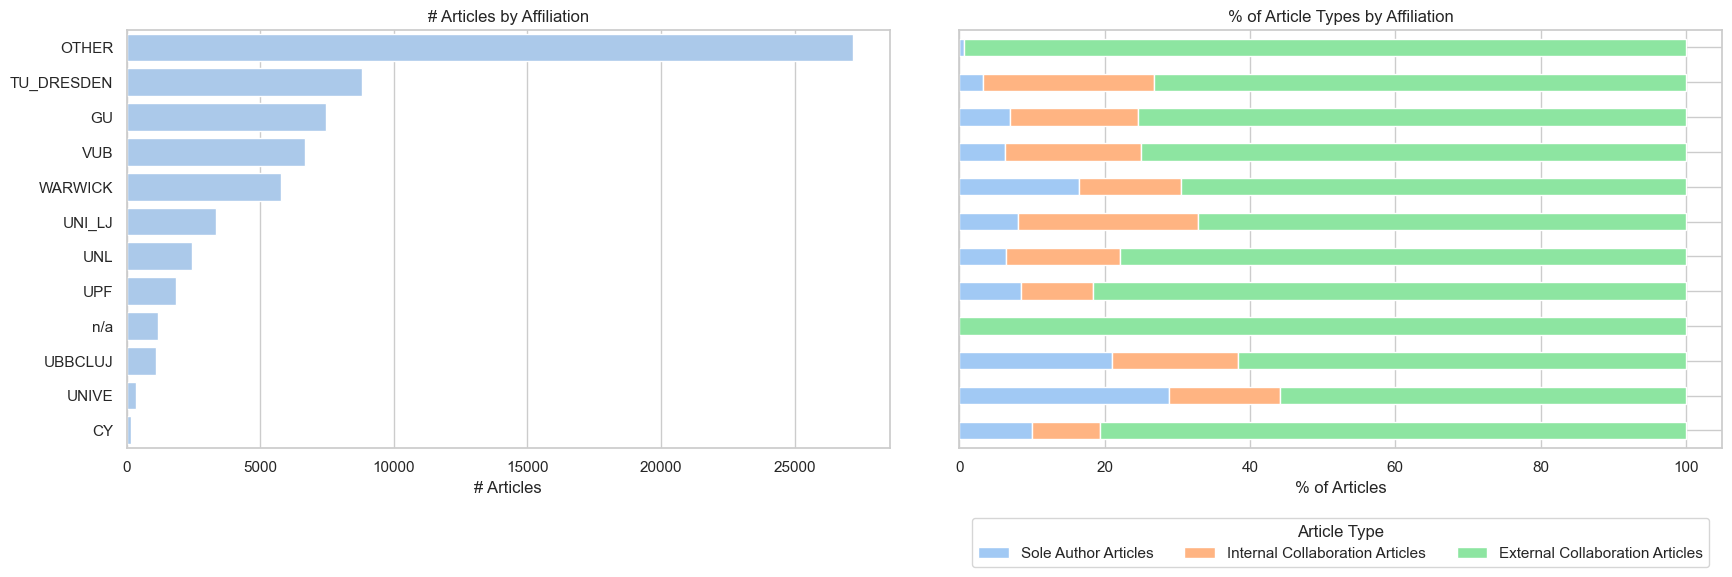

In [7]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Total Articles Plot
sns.barplot(ax=axes[0], data=df, x='TOTAL_ARTICLES', y='INSTITUTION_SID')
axes[0].set_title('# Articles by Affiliation')
axes[0].set_xlabel('# Articles')
axes[0].set_ylabel('')

# 100% Stacked Bar Plot
df[['Sole Author Articles', 'Internal Collaboration Articles', 'External Collaboration Articles']].plot(
    kind='barh', stacked=True, ax=axes[1])
axes[1].set_title('% of Article Types by Affiliation')
axes[1].set_xlabel('% of Articles')
axes[1].set_ylabel('Affiliation')
legend = axes[1].legend(title='Article Type', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

plt.tight_layout()
plt.show()

## Collaboration funnel

We want to show the number of articles in a funnel visualization. We show the total number of articles, how many of them are collaborations, how many of them are EUTOPIAan collaborations and how many of them are both. 

The number of articles is defined as the number of unique DOIs in the dataset.

### Process the data

1. Query the data from BigQuery
2. Extract the values for the funnel visualization

In [8]:
# Define the SQL query
sql_query = f"""
SELECT COUNT(DISTINCT ARTICLE_SID) AS TOTAL_ARTICLES
     , COUNT(DISTINCT IF(IS_EXTERNAL_COLLABORATION OR IS_INTERNAL_COLLABORATION, ARTICLE_SID, NULL)) AS ARTICLE_COLLABORATIONS
     , COUNT(DISTINCT IF(IS_EXTERNAL_COLLABORATION AND IS_EXTERNAL_COLLABORATION, ARTICLE_SID, NULL)) AS ARTICLE_EXTERNAL_COLLABORATIONS
     , COUNT(DISTINCT IF(IS_EXTERNAL_COLLABORATION AND IS_EXTERNAL_COLLABORATION AND IS_EUTOPIAN_COLLABORATION, ARTICLE_SID, NULL)) AS EUTOPIAN_COLLABORATION_ARTICLES
FROM {schema}.FCT_COLLABORATION
WHERE IS_ARTICLE_RELEVANT
"""

# Execute the query and store the result in a DataFrame
query_job = client.query(sql_query)
df = query_job.to_dataframe()

# Extract the values for funnel visualization
values = df.iloc[0].tolist()
labels = ["Total Articles", "Collaboration Articles", "External Collaboration Articles",
          "EUTOPIA Collaboration Articles"]

### Plotting
We plot the funnel visualization using a horizontal bar chart. We invert the y-axis to have the largest bar on top and add labels to the bars.

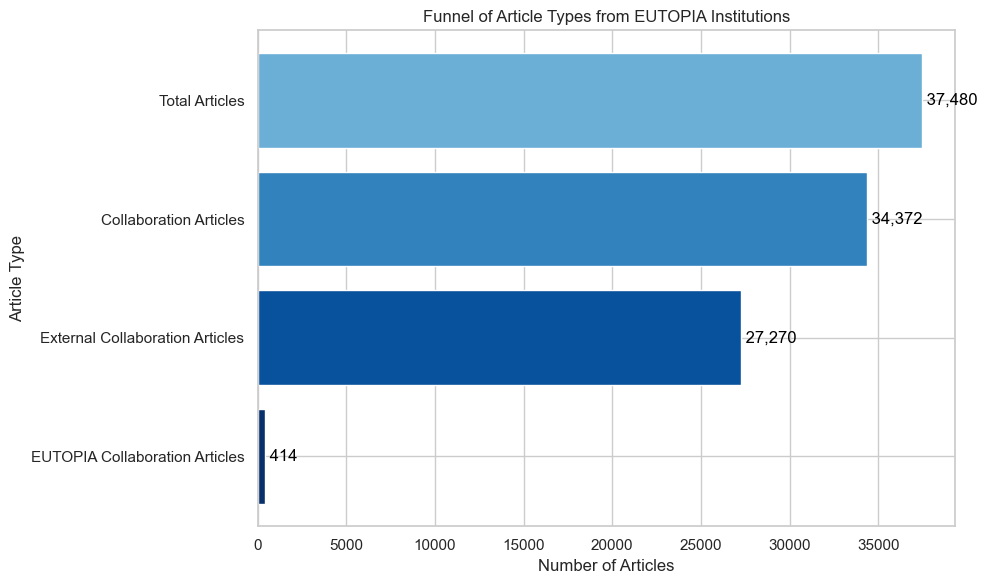

In [9]:
# Funnel Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create a horizontal bar chart
ax.barh(labels, values, color=['#6baed6', '#3182bd', '#08519c', '#08306b'])

# Invert y-axis to have the largest bar on top
ax.invert_yaxis()

# Add labels to the bars
for index, value in enumerate(values):
    ax.text(value, index, f' {value:,}', va='center', ha='left', color='black')

# Add title and labels
plt.title('Funnel of Article Types from EUTOPIA Institutions')
plt.xlabel('Number of Articles')
plt.ylabel('Article Type')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Publication trends
We want to show the publication trends of EUTOPIA institutions. We show:
1. how many articles have been published by EUTOPIA institutions each year,
2. how many of them have been collaborations and
3. how EUTOPIA-an collaborations are trending.

### Process the data
1. Query the data from BigQuery

In [11]:
# Define the SQL query
sql_query = f"""
SELECT EXTRACT(YEAR FROM ARTICLE_PUBLICATION_DT)                                                        AS YEAR
     , COUNT(DISTINCT ARTICLE_SID)                                                                      AS TOTAL_ARTICLES
     , COUNT(DISTINCT IF(IS_INTERNAL_COLLABORATION OR IS_EXTERNAL_COLLABORATION, ARTICLE_SID, NULL))    AS COLLABORATION_ARTICLES
     , COUNT(DISTINCT IF(IS_EUTOPIAN_COLLABORATION, ARTICLE_SID, NULL))                                 AS EUTOPIAN_COLLABORATION_ARTICLES
     , COUNT(DISTINCT IF(IS_SOLE_AUTHOR_PUBLICATION, ARTICLE_SID, NULL))                                AS SOLE_AUTHOR_ARTICLES
FROM {schema}.FCT_COLLABORATION
WHERE IS_ARTICLE_RELEVANT
AND EXTRACT(YEAR FROM ARTICLE_PUBLICATION_DT) > 2000
GROUP BY 1
"""
# Execute the query and store the result in a DataFrame
query_job = client.query(sql_query)
df = query_job.to_dataframe()
# 
# Convert YEAR to integer for better plotting
df['YEAR'] = df['YEAR'].astype(int)
df.sort_values('YEAR', inplace=True, ascending=True)

### Plotting
We plot the publication trends of EUTOPIA institutions using two subplots. The first subplot shows the total number of articles and the number of collaboration articles each year. The second subplot shows the number of EUTOPIAan collaboration articles each year.

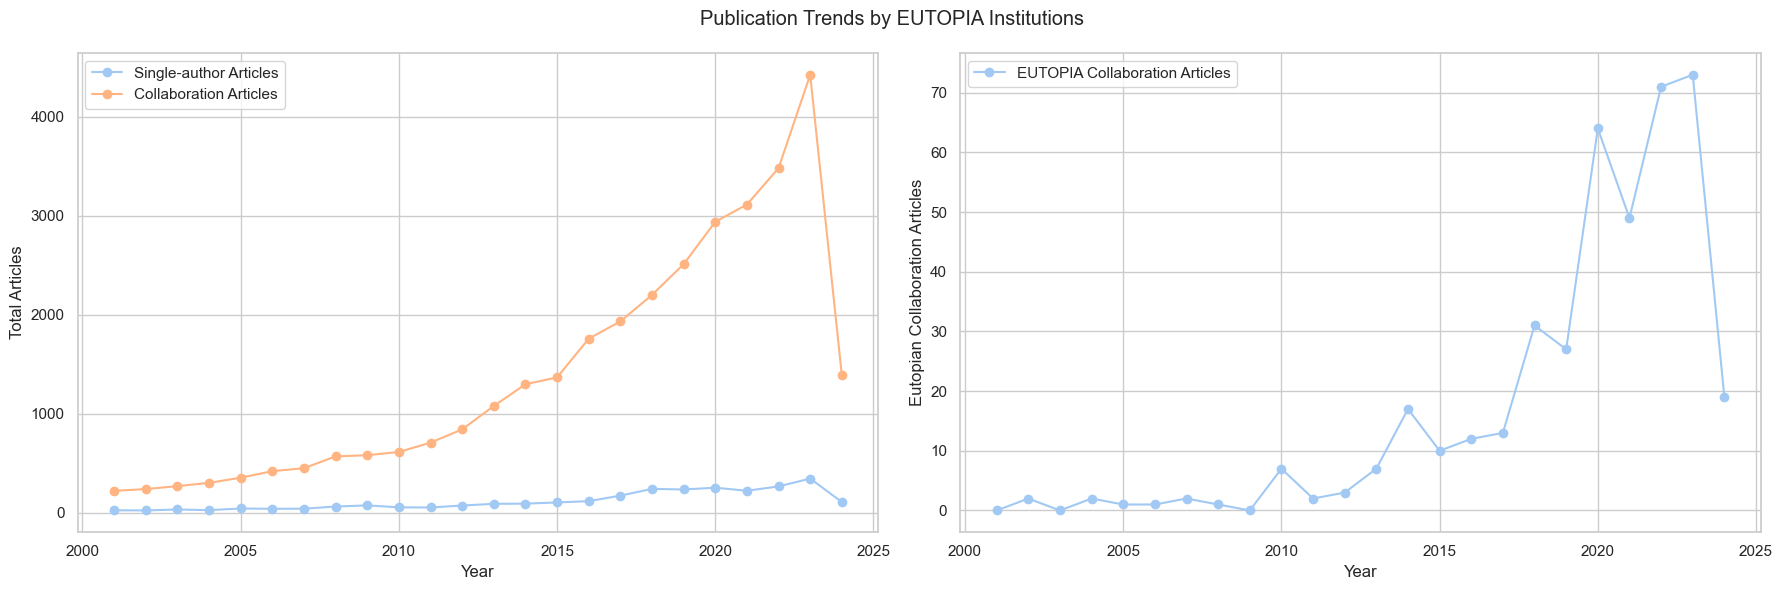

In [12]:
# Set up the plot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# First subplot for Total Articles
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Articles')
ax1.plot(df['YEAR'], df['SOLE_AUTHOR_ARTICLES'], label='Single-author Articles', marker='o')
ax1.plot(df['YEAR'], df['COLLABORATION_ARTICLES'], label='Collaboration Articles', marker='o')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Second subplot for Eutopian Collaboration Articles
color = 'tab:green'
ax2.set_xlabel('Year')
ax2.set_ylabel('Eutopian Collaboration Articles')
ax2.plot(df['YEAR'], df['EUTOPIAN_COLLABORATION_ARTICLES'], label='EUTOPIA Collaboration Articles',
         marker='o')
ax2.tick_params(axis='y')
ax2.legend(loc='upper left')

# Title and show
plt.suptitle('Publication Trends by EUTOPIA Institutions')
# Adjust layout
plt.tight_layout()
plt.show()